In [9]:
import os
import glob
import pandas as pd
from sklearn.model_selection import train_test_split

# Veri kümesiyle ilgili temel ayarlamaları yaptık

BASE_DIR = "data"                  # Görüntülerin bulunduğu ana dizini belirledik
OUTPUT_PATH = "outputs/splits.csv" # Oluşturulacak CSV dosyasının yolunu tanımladık
RANDOM_SEED = 42                   # Deneylerin tekrarlanabilir olması için sabit bir seed kullandık

# Çalışmada kullanılacak hava durumu sınıflarını belirledik
weather_classes = [
    "sunny_weather",
    "cloudy_weather",
    "rainy_weather",
    "snowy_weather"
]

# Görüntü dosyalarının yollarını ve etiketlerini tutmak için boş bir liste oluşturduk
image_records = []

# Klasör yapısını tarayarak görüntü yollarını ve etiketleri topladık

for label in weather_classes:
    folder_path = os.path.join(BASE_DIR, label)

    # İlgili sınıfa ait klasörün mevcut olup olmadığını kontrol ettik
    if not os.path.exists(folder_path):
        print(f" Uyarı: {folder_path} klasörü bulunamadı")
        continue

    # Klasör içindeki tüm görüntü dosyalarının yollarını aldık
    image_paths = glob.glob(os.path.join(folder_path, "*"))

    # Her bir görüntü için dosya yolu ve sınıf etiketini kaydettik
    for path in image_paths:
        image_records.append({
            "path": path,
            "label": label
        })

# Toplanan verileri pandas DataFrame yapısına dönüştürdük
df = pd.DataFrame(image_records)

# Veri kümesine ait genel bilgileri ekrana yazdırdık
print(f"\nToplam görüntü sayısı: {len(df)}")
print("\n Sınıf dağılımı:")
print(df["label"].value_counts())


# Veri kümesini eğitim, doğrulama ve test olarak ayırdık . Sınıf dengesini korumak için stratified splitting kullandık

train_df, remaining_df = train_test_split(
    df,
    test_size=0.30,
    random_state=RANDOM_SEED,
    stratify=df["label"]
)

val_df, test_df = train_test_split(
    remaining_df,
    test_size=0.50,
    random_state=RANDOM_SEED,
    stratify=remaining_df["label"]
)

# Her bir alt veri kümesine ait olduğu split bilgisini ekledik
train_df = train_df.assign(split="train")
val_df   = val_df.assign(split="val")
test_df  = test_df.assign(split="test")

# Eğitim, doğrulama ve test verilerini tek bir DataFrame altında birleştirdik
final_df = pd.concat([train_df, val_df, test_df], ignore_index=True)


# Oluşturulan veri kümesini dosyaya kaydettik

os.makedirs("outputs", exist_ok=True)
final_df.to_csv(OUTPUT_PATH, index=False)

# Bölme işleminin başarılı olduğunu ve dağılımları kontrol ettik
print("\n==============================")
print("    VERİ KÜMESİ ÖZETİ")
print("==============================")

print(f"Toplam görüntü sayısı: {len(df)}")

print("\nSınıf bazlı toplam dağılım:")
class_counts = df["label"].value_counts()
for label, count in class_counts.items():
    print(f"- {label:15s}: {count}")

print("\nSplit ve sınıf bazlı dağılım:")
split_counts = final_df.groupby(["split", "label"]).size()

for split in ["train", "val", "test"]:
    print(f"\n{split.upper()}:")
    for label in weather_classes:
        count = split_counts.get((split, label), 0)
        print(f"  {label:15s}: {count}")




Toplam görüntü sayısı: 1653

 Sınıf dağılımı:
label
snowy_weather     700
rainy_weather     400
cloudy_weather    300
sunny_weather     253
Name: count, dtype: int64

    VERİ KÜMESİ ÖZETİ
Toplam görüntü sayısı: 1653

Sınıf bazlı toplam dağılım:
- snowy_weather  : 700
- rainy_weather  : 400
- cloudy_weather : 300
- sunny_weather  : 253

Split ve sınıf bazlı dağılım:

TRAIN:
  sunny_weather  : 177
  cloudy_weather : 210
  rainy_weather  : 280
  snowy_weather  : 490

VAL:
  sunny_weather  : 38
  cloudy_weather : 45
  rainy_weather  : 60
  snowy_weather  : 105

TEST:
  sunny_weather  : 38
  cloudy_weather : 45
  rainy_weather  : 60
  snowy_weather  : 105




Özellikler daha önce kaydedilmiş, dosyadan yüklendi


---------------------------------------------
  XGBOOST MODEL SONUÇLARI
Accuracy  : 0.815
Macro F1  : 0.819
---------------------------------------------


---------------------------------------------
SINIF BAZLI PERFORMANS
Sınıf           Precision Recall F1-Score  Support
---------------------------------------------
cloudy_weather    0.79   0.84   0.82       45
rainy_weather     0.73   0.73   0.73       60
snowy_weather     0.84   0.83   0.83      105
sunny_weather     0.92   0.87   0.89       38
---------------------------------------------
Macro Avg         0.82   0.82   0.82      248
---------------------------------------------




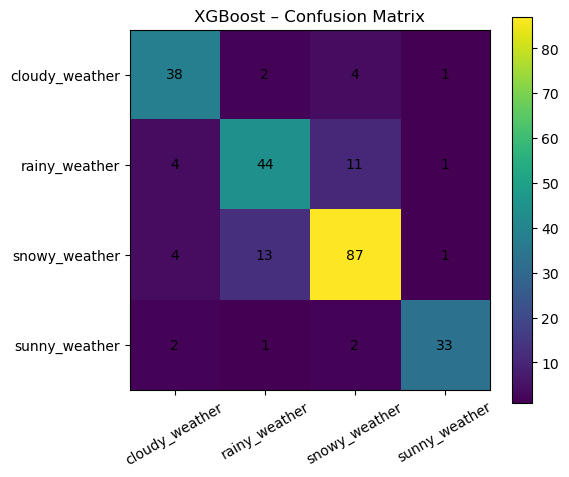

In [12]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
from xgboost import XGBClassifier

# Görüntüleri küçülterek işlemleri biraz daha hızlandırdık
IMAGE_SIZE = (96, 96)

# Özellikleri tekrar çıkarmamak için kaydedilecek dosyalar
FEATURES_FILE = "outputs/features.npy"
LABELS_FILE   = "outputs/labels.npy"
SPLITS_FILE   = "outputs/splits.npy"

# Görüntüden basit özellik çıkarma 
def extract_features(img):
    # Aynı boyuta getirdik
    img = cv2.resize(img, IMAGE_SIZE)

    # HSV renk uzayına çevirdik
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

    features = []

    # Her kanal için renk histogramı çıkardık
    for i in range(3):
        h = cv2.calcHist([hsv], [i], None, [16], [0, 256])
        h = cv2.normalize(h, h).flatten()
        features.append(h)

    # Gri görüntüden basit istatistikler aldık
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    features.append(np.array([
        gray.mean(),
        gray.std()
    ]))

    # Tüm özellikleri birleştirdik
    return np.concatenate(features)



# Basit veri çoğaltma (sadece train için)
def augment_image(img):
    images = [img]

    # Yatay çevirme
    images.append(cv2.flip(img, 1))

    return images


# Daha önce ayırdığımız train / test bilgilerini okuduk
df = pd.read_csv("outputs/splits.csv")


# Özellikleri daha önce çıkardıysak dosyadan yükledik. Yoksa tek tek çıkarıp kaydettik

if os.path.exists(FEATURES_FILE) and os.path.exists(LABELS_FILE) and os.path.exists(SPLITS_FILE):
    print("\n");
    print("Özellikler daha önce kaydedilmiş, dosyadan yüklendi")

    X = np.load(FEATURES_FILE)
    y = np.load(LABELS_FILE)
    splits = np.load(SPLITS_FILE)

else:
    print("\n");
    print("Özellikler ilk kez çıkarılıyor, bu biraz zaman alabilir")

    X, y, splits = [], [], []

    for i, row in df.iterrows():
        img = cv2.imread(row["path"])

        # Eğitim verisi için veri çoğaltma yaptık
        if row["split"] == "train":
            augmented_images = augment_image(img)

            for aug_img in augmented_images:
                X.append(extract_features(aug_img))
                y.append(row["label"])
                splits.append("train")
        else:
            # Test ve validation için orijinal görüntüyü kullandık
            X.append(extract_features(img))
            y.append(row["label"])
            splits.append(row["split"])

        if i % 100 == 0:
            print(f"{i} / {len(df)} görüntü işlendi")

    X = np.array(X)
    y = np.array(y)
    splits = np.array(splits)

    # Bir dahaki çalıştırmada hızlı olması için kaydettik
    np.save(FEATURES_FILE, X)
    np.save(LABELS_FILE, y)
    np.save(SPLITS_FILE, splits)
    
    print("\n");
    print("Özellikler kaydedildi")


# Train ve test verilerini ayırdık
X_train = X[splits == "train"]
X_test  = X[splits == "test"]

y_train = y[splits == "train"]
y_test  = y[splits == "test"]

# Etiketleri sayısal hale getirdik
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test  = le.transform(y_test)



# XGBoost modelini oluşturduk
model = XGBClassifier(
    objective="multi:softmax",
    num_class=4,
    n_estimators=200,
    max_depth=5,
    learning_rate=0.1,
    random_state=42
)

# Modeli eğitim verisiyle eğittik
model.fit(X_train, y_train)

# Test verisi üzerinde tahmin yaptık
y_pred = model.predict(X_test)

print("\n");
print("-" * 45);
print("==============================")
print("  XGBOOST MODEL SONUÇLARI")
print("==============================")

print(f"Accuracy  : {accuracy_score(y_test, y_pred):.3f}")
print(f"Macro F1  : {f1_score(y_test, y_pred, average='macro'):.3f}")

print("-" * 45);

# Daha düzenli sınıf bazlı tablo yazdırdık
report = classification_report(
    y_test,
    y_pred,
    target_names=le.classes_,
    output_dict=True
)
print("\n");
print("-" * 45);
print("==============================")
print("SINIF BAZLI PERFORMANS")
print("==============================")
print(f"{'Sınıf':15s} {'Precision':>6s} {'Recall':>6s} {'F1-Score':>6s} {'Support':>8s}")
print("-" * 45)

for label in le.classes_:
    r = report[label]
    print(f"{label:15s} {r['precision']:6.2f} {r['recall']:6.2f} {r['f1-score']:6.2f} {int(r['support']):8d}")

print("-" * 45)
print(f"{'Macro Avg':15s} "
      f"{report['macro avg']['precision']:6.2f} "
      f"{report['macro avg']['recall']:6.2f} "
      f"{report['macro avg']['f1-score']:6.2f} "
      f"{int(report['macro avg']['support']):8d}")

print("-" * 45);
print("\n");


# Confusion matrix çizdirdik
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 5))
plt.imshow(cm)
plt.colorbar()

plt.xticks(range(4), le.classes_, rotation=30)
plt.yticks(range(4), le.classes_)
plt.title("XGBoost – Confusion Matrix")

for i in range(4):
    for j in range(4):
        plt.text(j, i, cm[i, j], ha="center", va="center")

plt.tight_layout()
plt.show()


CNN Eğitimi Başladı...

Epoch [1/9] - Loss: 0.4633
Epoch [2/9] - Loss: 0.1710
Epoch [3/9] - Loss: 0.1154
Epoch [4/9] - Loss: 0.0921
Epoch [5/9] - Loss: 0.0905
Epoch [6/9] - Loss: 0.0941
Epoch [7/9] - Loss: 0.0627
Epoch [8/9] - Loss: 0.0677
Epoch [9/9] - Loss: 0.0608


---------------------------------------------
   CNN MODEL SONUÇLARI
Accuracy  : 0.952
Macro F1  : 0.954
---------------------------------------------


---------------------------------------------
SINIF BAZLI PERFORMANS
Sınıf           Precision  Recall  F1-Score  Support
---------------------------------------------
cloudy_weather       0.96    1.00      0.98       45
rainy_weather        1.00    0.83      0.91       60
snowy_weather        0.91    1.00      0.95      105
sunny_weather        1.00    0.95      0.97       38
---------------------------------------------
Macro Avg            0.97    0.95      0.95      248
---------------------------------------------


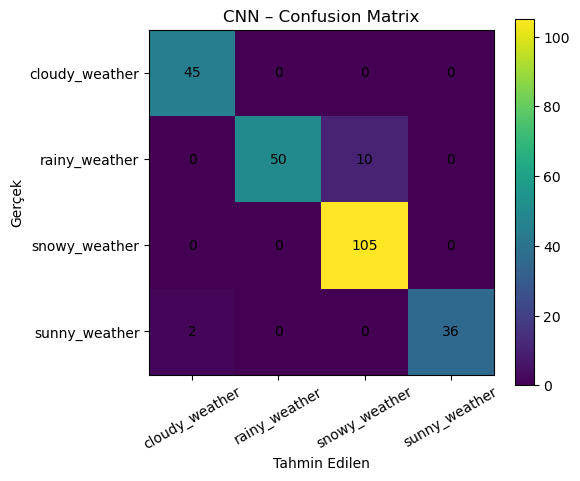

In [14]:
# CNN WEATHER CLASSIFICATION

import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from PIL import Image
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report


# Cihaz seçimini yaptık (GPU varsa GPU, yoksa CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# Özel Dataset sınıfını oluşturduk
class WeatherDataset(Dataset):
    def __init__(self, df, transform=None):
        # Veri çerçevesini ve dönüşümleri aldık
        self.df = df.reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        # Veri kümesinin toplam uzunluğunu döndürdük
        return len(self.df)

    def __getitem__(self, idx):
        # İlgili satırdan görüntü yolu ve etiket bilgisini aldık
        img_path = self.df.loc[idx, "path"]
        label = self.df.loc[idx, "label_enc"]

        # Görüntüyü okuduk ve RGB formatına çevirdik
        image = Image.open(img_path).convert("RGB")

        # Dönüşüm tanımlıysa görüntüye uyguladık
        if self.transform:
            image = self.transform(image)

        return image, label


# Daha önce oluşturduğumuz split dosyasını okuduk
df = pd.read_csv("outputs/splits.csv")

train_df = df[df["split"] == "train"].copy()
val_df   = df[df["split"] == "val"].copy()
test_df  = df[df["split"] == "test"].copy()


# Sınıf etiketlerini sayısal hale getirdik
le = LabelEncoder()
train_df["label_enc"] = le.fit_transform(train_df["label"])
val_df["label_enc"]   = le.transform(val_df["label"])
test_df["label_enc"]  = le.transform(test_df["label"])


# TRAIN için veri çoğaltma (augmentation) uyguladık
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),             # ResNet için uygun giriş boyutu
    transforms.RandomHorizontalFlip(p=0.5),    # Yatay çevirme kullandık
    transforms.RandomRotation(10),             # Küçük açılı döndürme yaptık
    transforms.ColorJitter(
        brightness=0.2,
        contrast=0.2
    ),                                         # Parlaklık ve kontrastı biraz değiştirdik
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std =[0.229, 0.224, 0.225]
    )
])


# TEST için sade dönüşüm kullandık
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std =[0.229, 0.224, 0.225]
    )
])


# Dataset ve DataLoader yapılarını oluşturduk
train_ds = WeatherDataset(train_df, train_transform)
test_ds  = WeatherDataset(test_df, test_transform)

train_loader = DataLoader(train_ds, batch_size=16, shuffle=True)
test_loader  = DataLoader(test_ds, batch_size=16, shuffle=False)


# Önceden eğitilmiş ResNet18 modelini kullandık
model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)

# Son fully connected katmanı 4 sınıfa göre değiştirdik
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 4)

model = model.to(device)


# Kayıp fonksiyonu ve optimizer tanımladık
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)


# Modeli eğitim verisiyle eğittik
EPOCHS = 9
print("CNN Eğitimi Başladı...\n")

for epoch in range(EPOCHS):
    model.train()
    epoch_loss = 0

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.long().to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    print(f"Epoch [{epoch+1}/{EPOCHS}] - Loss: {epoch_loss/len(train_loader):.4f}")


# Modeli test verisi üzerinde değerlendirdik
model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        preds = torch.argmax(outputs, dim=1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())


# Genel Metrikler
acc = accuracy_score(y_true, y_pred)
macro_f1 = f1_score(y_true, y_pred, average="macro")

print("\n")
print("-" * 45)
print("==============================")
print("   CNN MODEL SONUÇLARI")
print("==============================")
print(f"Accuracy  : {acc:.3f}")
print(f"Macro F1  : {macro_f1:.3f}")
print("-" * 45)

# Sınıf Bazlı Performans Tablosu

report = classification_report(
    y_true,
    y_pred,
    target_names=le.classes_,
    output_dict=True
)

print("\n")
print("-" * 45)
print("==============================")
print("SINIF BAZLI PERFORMANS")
print("==============================")
print(f"{'Sınıf':15s} {'Precision':>9s} {'Recall':>7s} {'F1-Score':>9s} {'Support':>8s}")
print("-" * 45)

for label in le.classes_:
    r = report[label]
    print(f"{label:15s} "
          f"{r['precision']:9.2f} "
          f"{r['recall']:7.2f} "
          f"{r['f1-score']:9.2f} "
          f"{int(r['support']):8d}")

print("-" * 45)
print(f"{'Macro Avg':15s} "
      f"{report['macro avg']['precision']:9.2f} "
      f"{report['macro avg']['recall']:7.2f} "
      f"{report['macro avg']['f1-score']:9.2f} "
      f"{int(report['macro avg']['support']):8d}")
print("-" * 45)


# Confusion Matrix çizdirdik
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6, 5))
plt.imshow(cm)
plt.colorbar()

plt.xticks(range(4), le.classes_, rotation=30)
plt.yticks(range(4), le.classes_)
plt.xlabel("Tahmin Edilen")
plt.ylabel("Gerçek")
plt.title("CNN – Confusion Matrix")

for i in range(4):
    for j in range(4):
        plt.text(j, i, cm[i, j], ha="center", va="center")

plt.tight_layout()
plt.show()


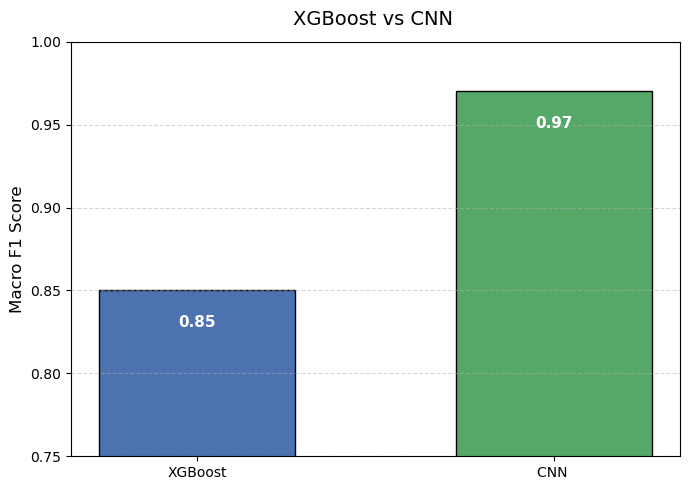

In [18]:
import matplotlib.pyplot as plt
import numpy as np

# Model isimleri ve Macro F1 skorları
models = ["XGBoost", "CNN "]
macro_f1_scores = [0.85, 0.97]

# Renk paleti 
colors = ["#4C72B0", "#55A868"]  # mavi & yeşil

plt.figure(figsize=(7, 5))

bars = plt.bar(
    models,
    macro_f1_scores,
    color=colors,
    width=0.55,
    edgecolor="black"
)

# Y eksenini biraz yukarıdan kestik
plt.ylim(0.75, 1.00)

plt.ylabel("Macro F1 Score", fontsize=12)
plt.title("XGBoost vs CNN ", fontsize=14, pad=12)

# Grid ekleyelim 
plt.grid(axis="y", linestyle="--", alpha=0.5)

# Bar üstüne değerleri düzgün yerleştirelim
for bar, score in zip(bars, macro_f1_scores):
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        score - 0.015,              # barın içine alıyoruz
        f"{score:.2f}",
        ha="center",
        va="top",
        fontsize=11,
        fontweight="bold",
        color="white"
    )

plt.tight_layout()
plt.show()
